In [2]:
!pip install transformers
!pip install datasets

In [4]:
import sklearn
from sklearn import decomposition
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import numpy as np
import torch
from torch import optim
from transformers import AdamW


In [5]:
def pca(hidden_states, n=2):
  covariance_matrix = np.cov(np.array(hidden_states).T)
  eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
  projection_matrix = (eigen_vectors.T[:][:n]).T
  x_pca = np.array(hidden_states).dot(projection_matrix)

  return x_pca

In [6]:
###########
# MASKED LANGUAGE MODELS BERT: For training BERT gets a sentence and the goal is that it outputs the same sentence again. But this procedure is done with "mask tokens",
# where basically words of the sentence are left out so BERT can predict them and learn the semantics.

<h1>**Training Transfomer from pre-trained Distilbert**</h1>

In [7]:
from datasets import load_dataset
imdb = load_dataset("imdb")

imdb = imdb.shuffle()

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
  
tokenized_imdb = imdb.map(preprocess_function, batched=True, batch_size=64)

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/391 [00:00<?, ?ba/s]

  0%|          | 0/391 [00:00<?, ?ba/s]

  0%|          | 0/782 [00:00<?, ?ba/s]

In [8]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [14]:
from transformers import TrainingArguments, Trainer

def init_trainer(model):

  training_args = TrainingArguments(
      output_dir='./results',
      learning_rate=2e-5,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      num_train_epochs=1,
      weight_decay=0.01,
  )

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_imdb["train"].select([*range(500)]),
      eval_dataset=tokenized_imdb["test"].select([*range(100)]),
      tokenizer=tokenizer,
      data_collator=data_collator,
  )

  return trainer

trainer = init_trainer(model)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [15]:
#trainer.train()


<h1>*Train model and save hidden states for each epoch and each layer*</h1>

In [16]:
import numpy as np
import torch
from torch import optim

from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-2)

In [17]:
epochs = 5
samples = 300
loss_list = []

device = "cuda:0"

hiddens_array = np.zeros((epochs,samples,7,768))   # distilbert has 7 layers states and 768 hidden dim
labels = np.zeros((samples))
for epoch in range(epochs):
  trainer = init_trainer(model)
  trainer.train()
  for i in range(0,samples): 

    sample = tokenized_imdb["train"].select([i])
    label = sample["label"]
    labels[i] = label[0]
    enc_ = tokenizer(sample["text"],return_tensors='pt', truncation=True, padding="max_length")
    mask = enc_["attention_mask"].to(device)
    hidden_states = model(**enc_.to(device), output_hidden_states=True)["hidden_states"]
    

    for idx,layer_hidden_states in enumerate(hidden_states): 
      hiddens_array[epoch,i,idx] = torch.div(layer_hidden_states.sum(dim=1),mask.sum(dim=1,keepdim=True)).cpu().detach().numpy()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




In [18]:
hiddens_array.shape # (5 epochs, 300 samples, 7 layers, 768 embedding dim)

(5, 300, 7, 768)

In [19]:
import sklearn
from sklearn import decomposition
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pca = decomposition.PCA(n_components=3)

layers = 6

layer_vis = pca.fit_transform(hiddens_array[0,:,6,:])
#layer_vis = TSNE(n_components=2).fit_transform(hiddens_array[6,:,23,:])


<h2>*Visualization of last hidden states per epoch*</h2>

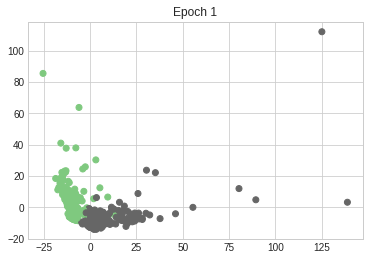

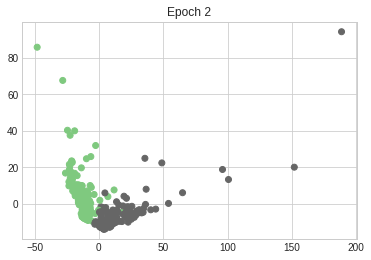

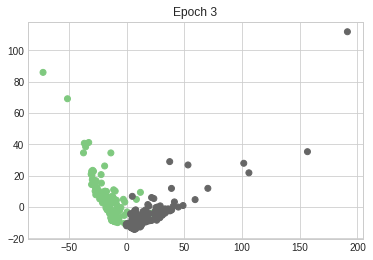

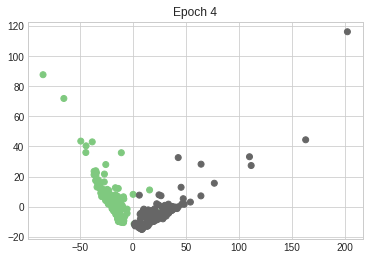

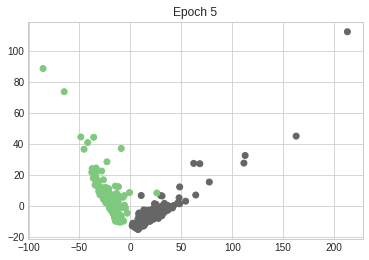

In [20]:
for i in range(epochs):
  layer_vis = pca.fit_transform(hiddens_array[i,:,6,:])
  fig, ax = plt.subplots()
  plt.title("Epoch " + str(i+1))
  ax.scatter(layer_vis[:,0], layer_vis[:,1],c=labels, cmap='Accent',  )

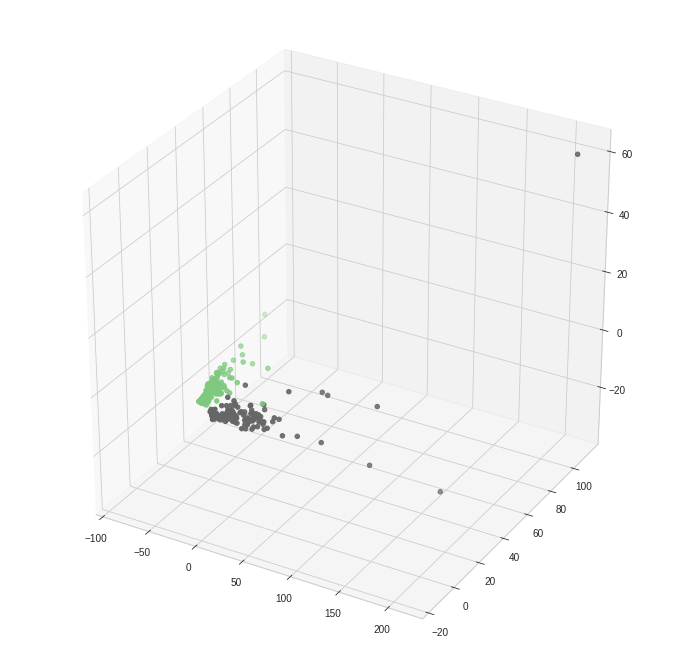

In [21]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(layer_vis[:,0], layer_vis[:,1], layer_vis[:,2],c=labels, cmap='Accent')

<h2>*Visualization of hidden states per epoch (column) and per layer (row)*</h2>

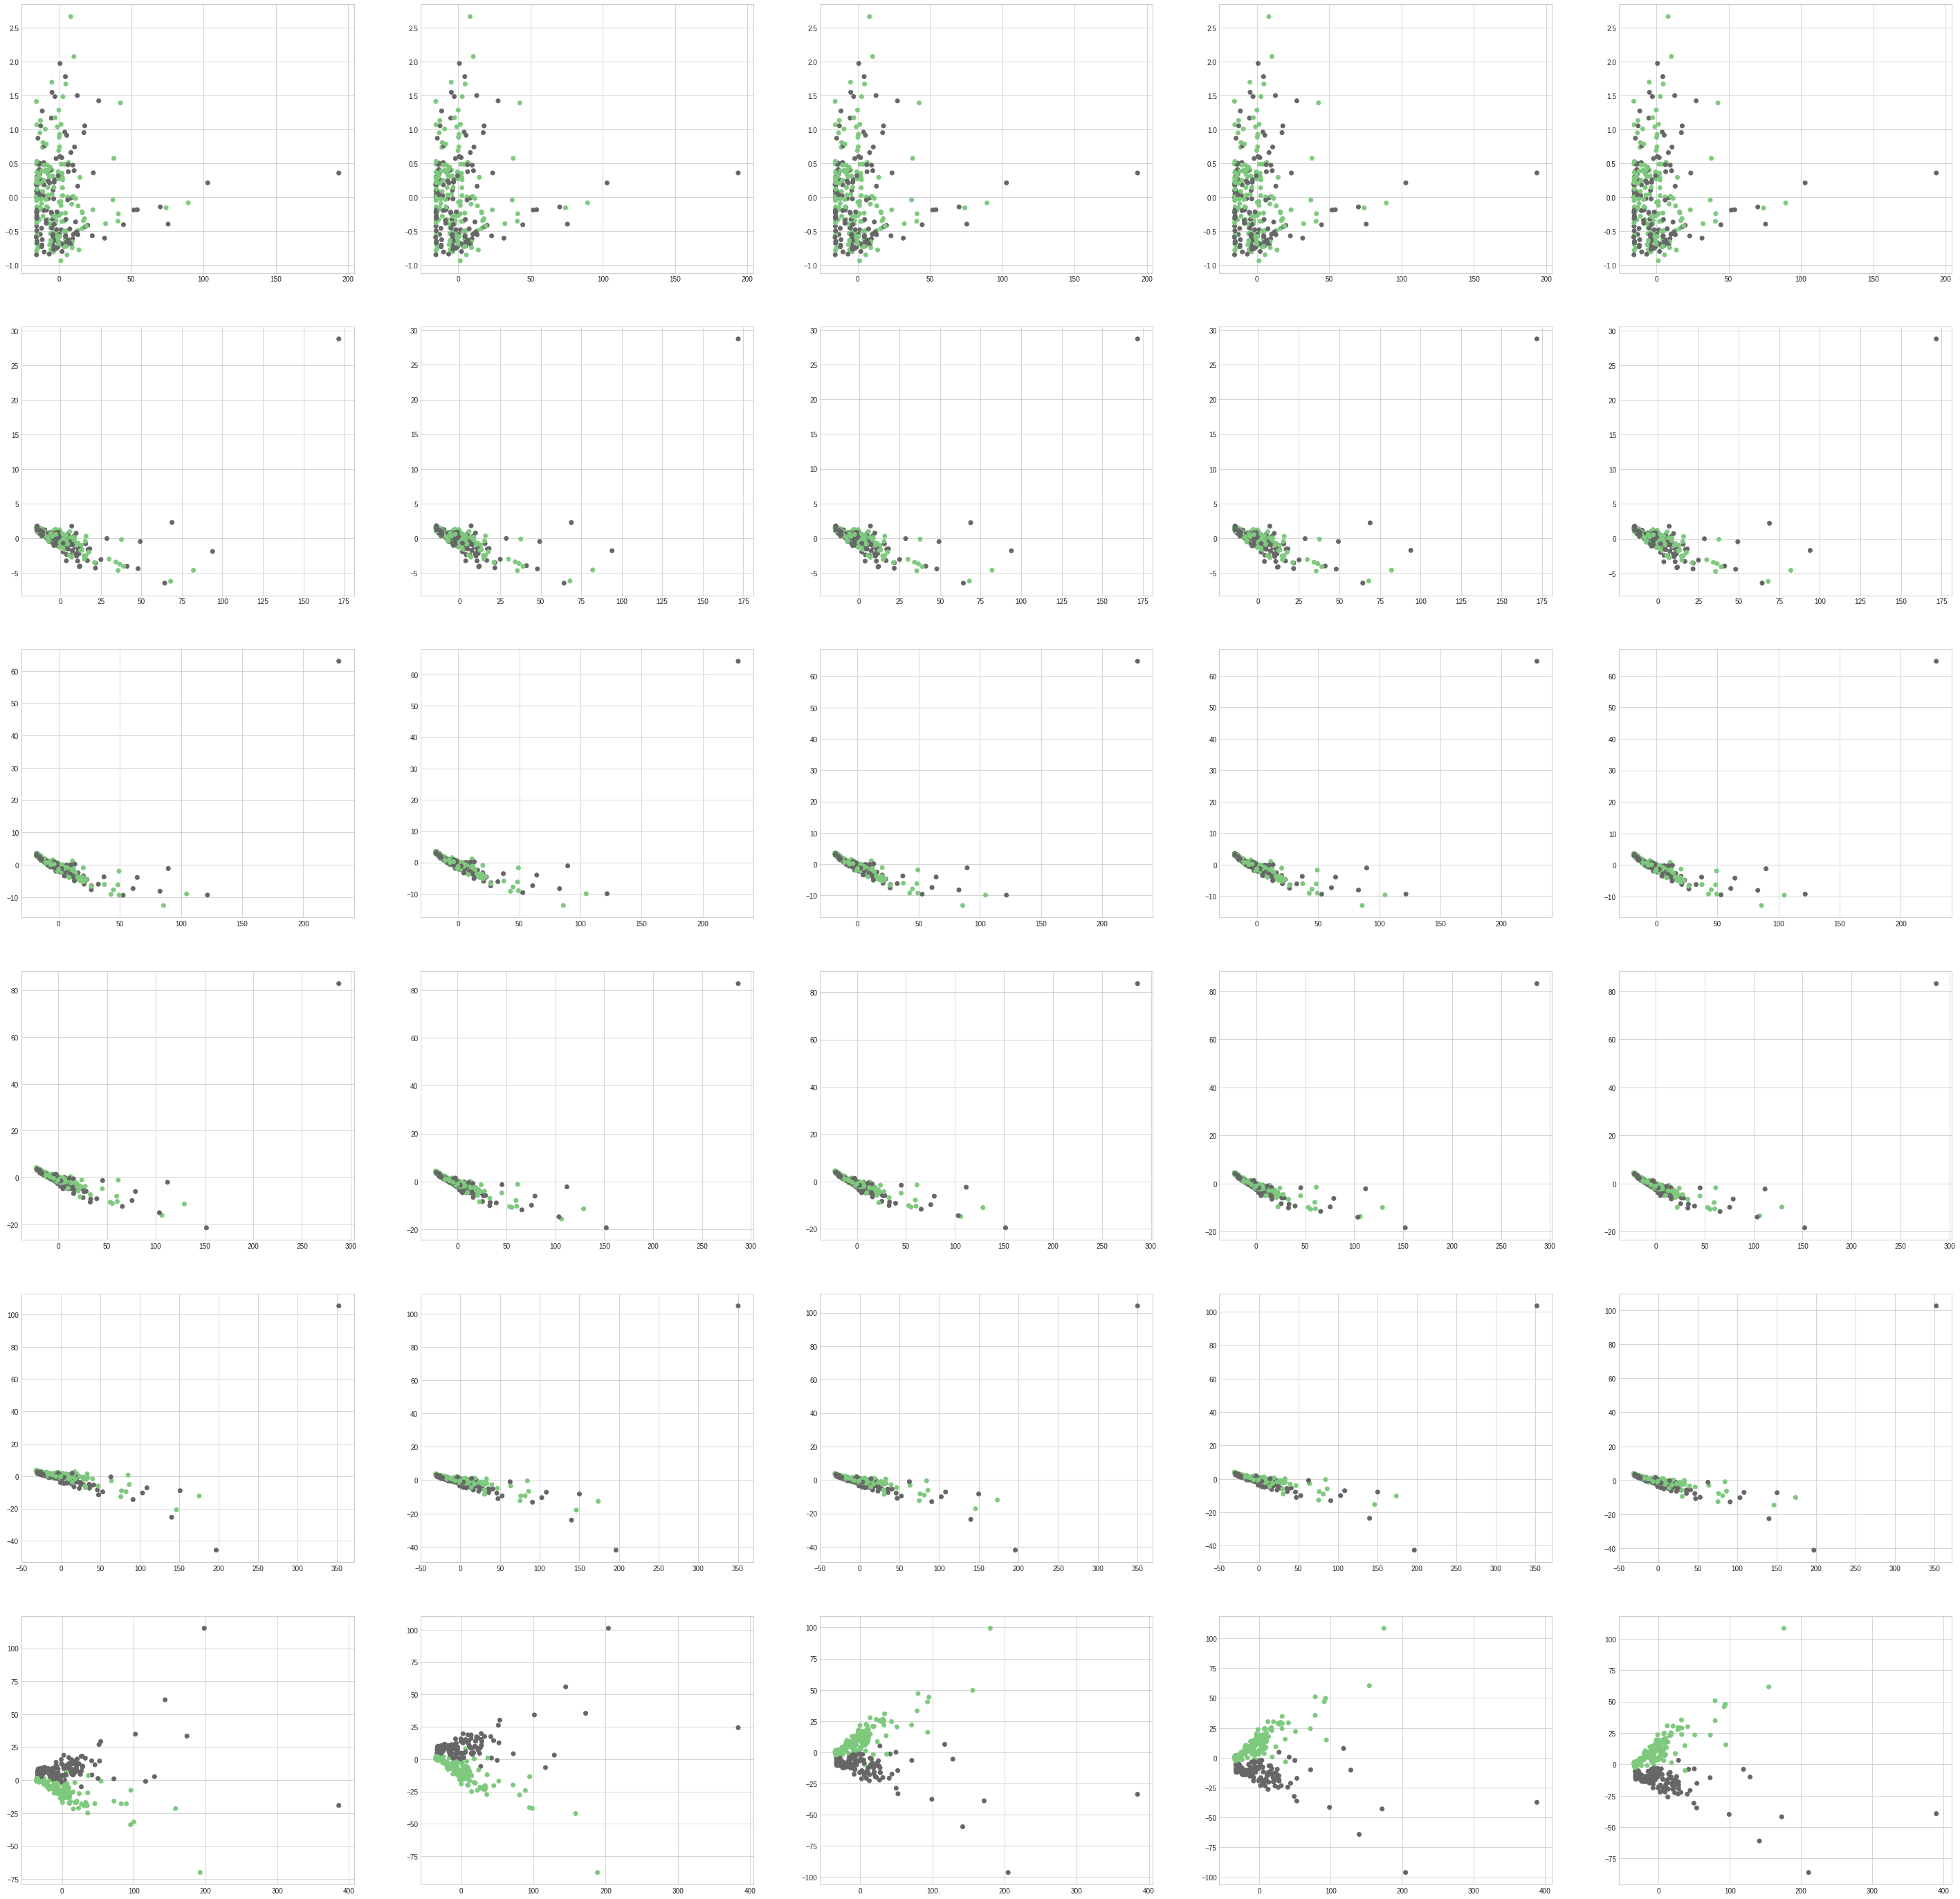

In [22]:

fig, ax = plt.subplots(nrows=layers, ncols=epochs, figsize=(50,50))
i=0
for layer, row in enumerate(ax):
    for ax in row:
        layer_vis = pca.fit_transform(hiddens_array[i,:,layer,:])
        ax.scatter(layer_vis[:,0], layer_vis[:,1],c=labels, cmap='Accent' )
        i+=1
    i=0  

plt.show()